Weekly Tasks 2
Model the data to find the price based on the input features.



In [1]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn wordcloud xgboost statsmodels 

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import required libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

##### Load and Clean Data
In this section, we will load the dataset from a CSV file and clean it.
The cleaning process includes handling currency and area values,
converting relevant columns to numeric types, and renaming columns
to include units. We'll then display a summary of the cleaned dataset.


In [3]:
# Load the dataset
def load_data(file_path):
    """
    Load dataset from a CSV file.
    """
    try:
        data = pd.read_csv(file_path)
        print("Dataset loaded successfully.")
        return data
    except FileNotFoundError:
        print(f"File not found at {file_path}.")
        return None

# Clean the dataset
def clean_data(df):
    """
    Clean and preprocess the DataFrame.
    """
    # Function to clean currency and area columns
    def clean_value(val):
        if isinstance(val, str):
            val = val.replace('$', '').replace(',', '').replace('Contact For Price', '').strip()
            if val.endswith('/mo'):
                val = val[:-3]  # Remove '/mo'
            if val.endswith('sqft'):
                val = val[:-4]  # Remove 'sqft'
            if val.endswith('+'):
                val = val[:-1]  # Remove the '+' sign
            try:
                return float(val) if val else val
            except ValueError:
                return val
        return val

    # List of columns to clean
    cols_to_clean = ['Price', 'Sqr Ft', 'Price Sqr Ft', 'Lot Size', 'Last Sold For']

    for col in cols_to_clean:
        df[col] = df[col].apply(clean_value)

    # Convert relevant columns to numeric, keeping original values if conversion fails
    numeric_cols = ['Beds', 'Bath', 'Year Built', 'Zipcode']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].astype(object))

    # Update column names with units
    df = df.rename(columns={
        'Price': 'Price ($)',
        'Sqr Ft': 'Sqr Ft (sqft)',
        'Lot Size': 'Lot Size (sqft)',
        'Price Sqr Ft': 'Price Sqr Ft ($/sqft)',
        'Last Sold For': 'Last Sold For ($)'
    })

    return df

# Load and clean the data
file_path = 'houseprice.csv'
df = load_data(file_path)
if df is not None:
    df = clean_data(df)
    print("Data cleaning completed.")
    print("\nSummary of the cleaned dataset:")
    print(df.describe().round(2).to_string())
    
    print("\nFirst five rows of the cleaned dataset:")
    print(df.head().to_string(index=False))
    
    print("\nDataset information:")
    df.info()
    
    # Save the cleaned data to a CSV file
    cleaned_file_path = 'cleaned_data.csv'
    df.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned data saved to {cleaned_file_path}")
else:
    # Handle the case where data couldn't be loaded
    df = pd.DataFrame()

File not found at houseprice.csv.


#### Basic Exploratory Data Analysis (EDA)
    This section performs an in-depth EDA on the cleaned dataset:

    - Data Cleaning: Convert 'Price ($)' to numeric, standardize 'Lot Size (sqft)', format numeric features, apply log transformation to 'Price ($)'
    - Univariate Analysis: Visualize log-transformed house prices and key numeric features
    - Bivariate Analysis: Create correlation matrix heatmap and scatter plots
    - Categorical Variable Analysis: Analyze high cardinality features like 'City' and 'State'
    - Data Quality Checks: Implement column existence checks, handle missing values
    - Advanced Visualizations: Use seaborn for enhanced graphics, create multi-plot figures
    - Performance Considerations: Efficient data handling, appropriate plot sizes and layouts

    Insights from this analysis are saved in: Weekly Tasks\Visualisation Outputs\Insights\Task 2 EDA Insights.md


In [4]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        self.numeric_features = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price Sqr Ft ($/sqft)', 'Address', 'City', 'State', 'Address Full']
        self.output_folder = r"G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\Visualisation Outputs"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Convert 'Lot Size (sqft)' from acres to sqft if necessary.
        - Ensure all numeric features are converted to numeric data types.
        """
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Clean 'Lot Size (sqft)' column
        self.clean_lot_size_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def clean_lot_size_column(self):
        """Clean and convert 'Lot Size (sqft)' to numeric values in sqft."""
        if self.check_column_exists('Lot Size (sqft)'):
            # Apply conversion to each value in 'Lot Size (sqft)'
            self.df['Lot Size (sqft)'] = self.df['Lot Size (sqft)'].apply(self.convert_lot_size)
            # Convert the cleaned values to numeric
            self.df['Lot Size (sqft)'] = pd.to_numeric(self.df['Lot Size (sqft)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    @staticmethod
    def convert_lot_size(value):
        """
        Convert 'Lot Size (sqft)' from acres to sqft if applicable.

        Parameters:
        value: The value to convert.

        Returns:
        float: The converted lot size in sqft, or NaN if conversion fails.
        """
        try:
            if pd.isna(value):
                return np.nan
            value_str = str(value).strip().lower()
            if 'acres' in value_str:
                # Extract the numeric part and convert acres to sqft
                number = float(value_str.replace('acres', '').strip())
                return number * 43560
            else:
                # Remove commas and convert to float
                return float(value_str.replace(',', ''))
        except (ValueError, TypeError):
            return np.nan

    def plot_distribution(self, column_name, title, xlabel):
        """
        Plot the distribution of a given numeric column.

        Parameters:
        column_name (str): The name of the column to plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        """
        if self.check_column_exists(column_name):
            plt.figure(figsize=(10, 6))
            sns.histplot(self.df[column_name].dropna(), bins=50, kde=True)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, f"{title.replace(' ', '_')}.png"))
            plt.close()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix for numeric features.
        """
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != 'Price ($)']
        if numeric_cols:
            plt.figure(figsize=(12, 10))
            corr_matrix = self.df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Correlation_Matrix.png"))
            plt.close()

    def plot_scatter_plots(self):
        """
        Generate scatter plots for each numeric feature against Log Price.
        """
        if self.check_column_exists('Log Price ($)'):
            valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
            num_plots = len(valid_features)
            rows = (num_plots + 1) // 2
            fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
            axes = axes.flatten()
            for idx, feature in enumerate(valid_features):
                sns.scatterplot(
                    data=self.df,
                    x=feature,
                    y='Log Price ($)',
                    ax=axes[idx]
                )
                axes[idx].set_title(f'{feature} vs. Log Price')
                axes[idx].set_xlabel(feature)
                axes[idx].set_ylabel('Log Price ($)')
            # Remove any unused subplots
            for idx in range(num_plots, len(axes)):
                fig.delaxes(axes[idx])
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Scatter_Plots.png"))
            plt.close()

    def handle_high_cardinality_features(self):
        """
        Visualize high cardinality features like 'City' and 'State' by plotting average prices.
        """
        for col in self.high_cardinality_cols:
            if self.check_column_exists(col):
                if col in ['State', 'City']:
                    plt.figure(figsize=(12, 6))
                    avg_price = self.df.groupby(col)['Price ($)'].mean().nlargest(20)
                    avg_price.plot(kind='bar')
                    plt.title(f'Average House Price by {col}')
                    plt.xlabel(col)
                    plt.ylabel('Average Price ($)')
                    plt.tight_layout()
                    plt.savefig(os.path.join(self.output_folder, f"Average_Price_by_{col}.png"))
                    plt.close()

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Plot distributions
        - Plot correlation matrix
        - Plot scatter plots
        - Handle high cardinality features
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Plot distributions
        self.plot_distribution('Log Price ($)', 'Log-Transformed Distribution of House Prices', 'Log Price ($)')

        # Plot correlation matrix
        self.plot_correlation_matrix()

        # Plot scatter plots
        self.plot_scatter_plots()

        # Handle high cardinality features
        self.handle_high_cardinality_features()
        print("EDA completed successfully.")

# Main execution
def main():
    file_path = r"G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\cleaned_data.csv"

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print("Error: The dataframe is empty. Unable to perform EDA.")
            else:
                print(f"Data loaded successfully. Shape: {df.shape}")
                eda = ExploratoryDataAnalysis(df)
                eda.perform_eda()
        except Exception as e:
            print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()



Data loaded successfully. Shape: (30006, 16)
Starting EDA...
Data cleaned successfully.
EDA completed successfully.


#### Advanced Exploratory Data Analysis (EDA)
This section performs an advanced EDA on the cleaned dataset:

    ##### Data Preparation and Cleaning
    - Initialize EDA class, define feature categories
    - Clean 'Price ($)' and 'Lot Size (sqft)'
    - Convert numeric features, apply log transformation to 'Price ($)'

    ##### Categorical Variable Analysis
    - Generate box plots for top categories
    - Visualize price distributions across categorical features

    ##### Price per Square Foot Analysis
    - Clean and transform data, handle outliers
    - Create histograms for original and log-transformed values

    ##### Text Data Visualization
    - Generate word clouds or plot top 20 common words

    ##### Advanced Visualization Techniques
    - Use seaborn for enhanced graphics
    - Implement multi-plot figures for feature comparisons

    ##### Data Integrity and Error Handling
    - Check column existence, handle missing values
    - Incorporate robust error handling

    ##### Performance and Scalability
    - Efficient data handling for large datasets
    - Appropriate plot sizes and layouts

    ##### Output Management
    - Save plots in dedicated folder
    - Provide informative console outputs

    Insights from this analysis are saved in Weekly Tasks\Visualisation Outputs\Insights\Task 2 EDA Insights.md


Data loaded successfully. Shape: (30006, 16)
Starting EDA...
Cleaning data...
Data cleaned successfully.
Plotting box plots for categorical variables...


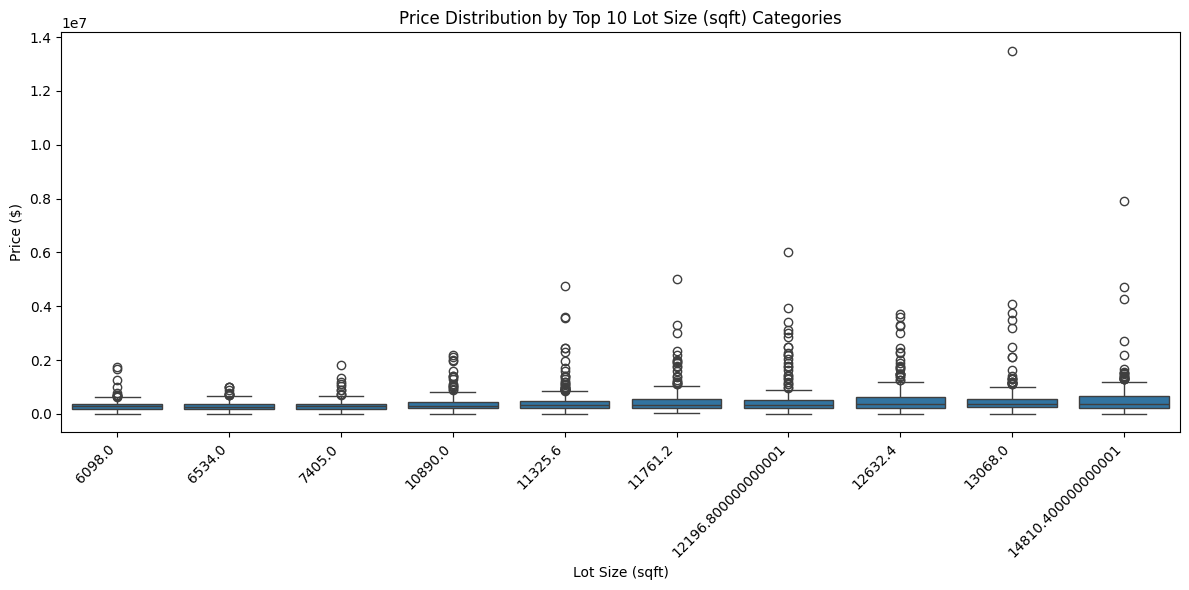

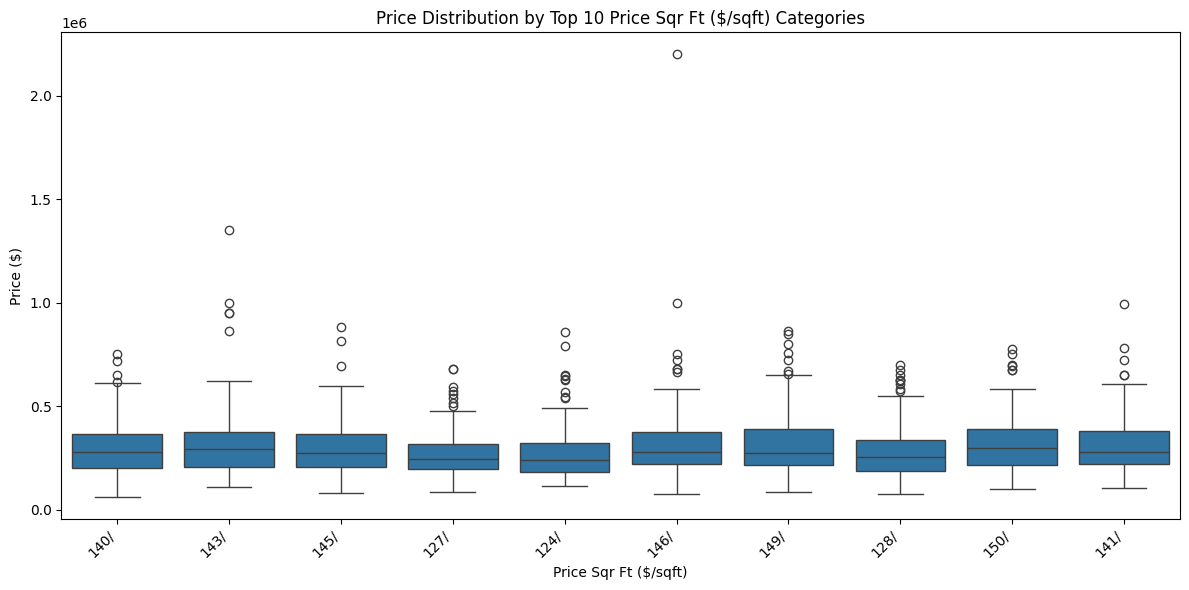

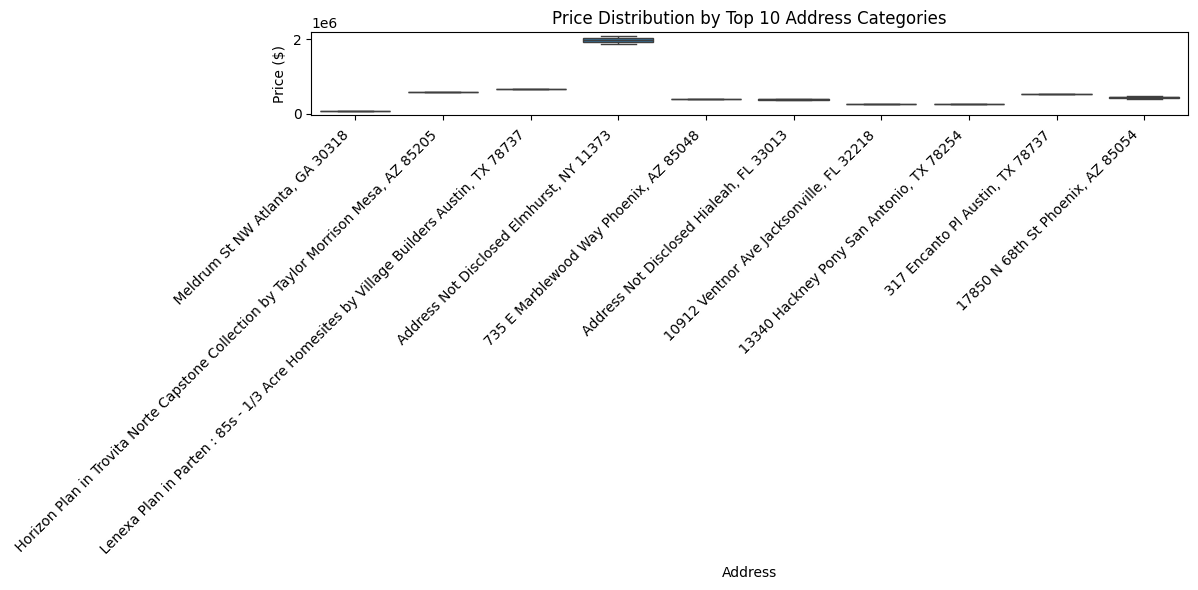

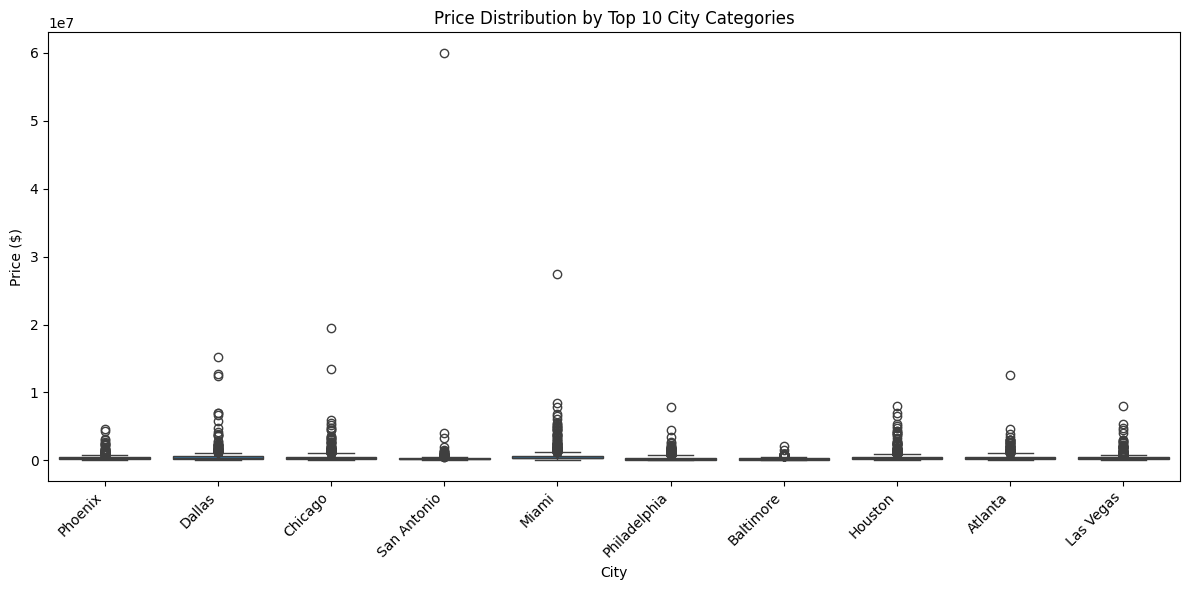

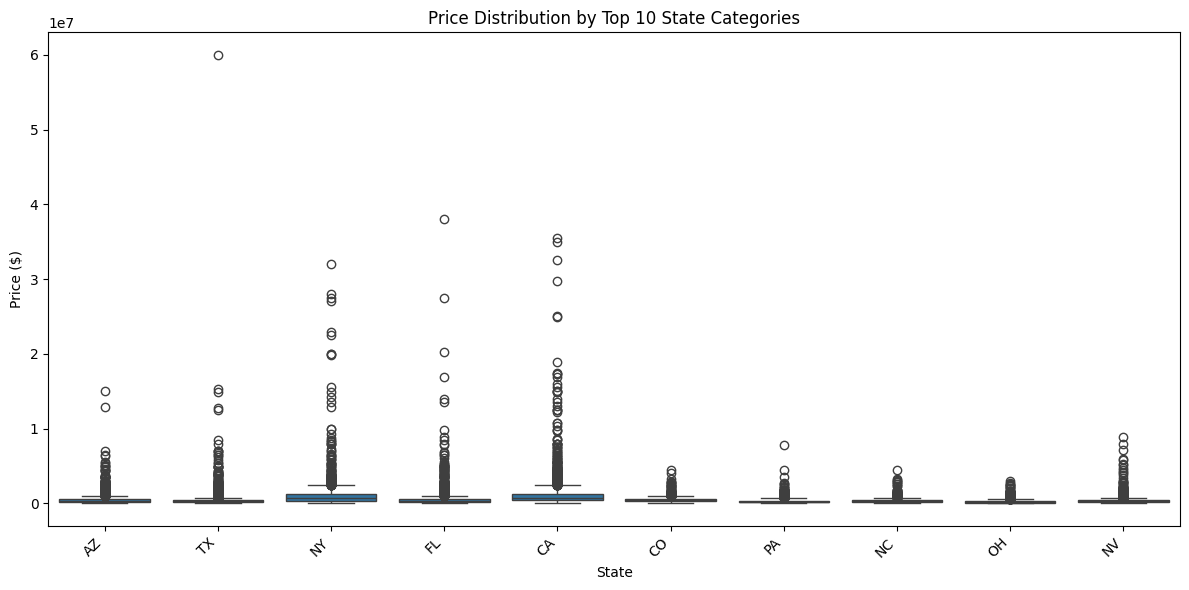

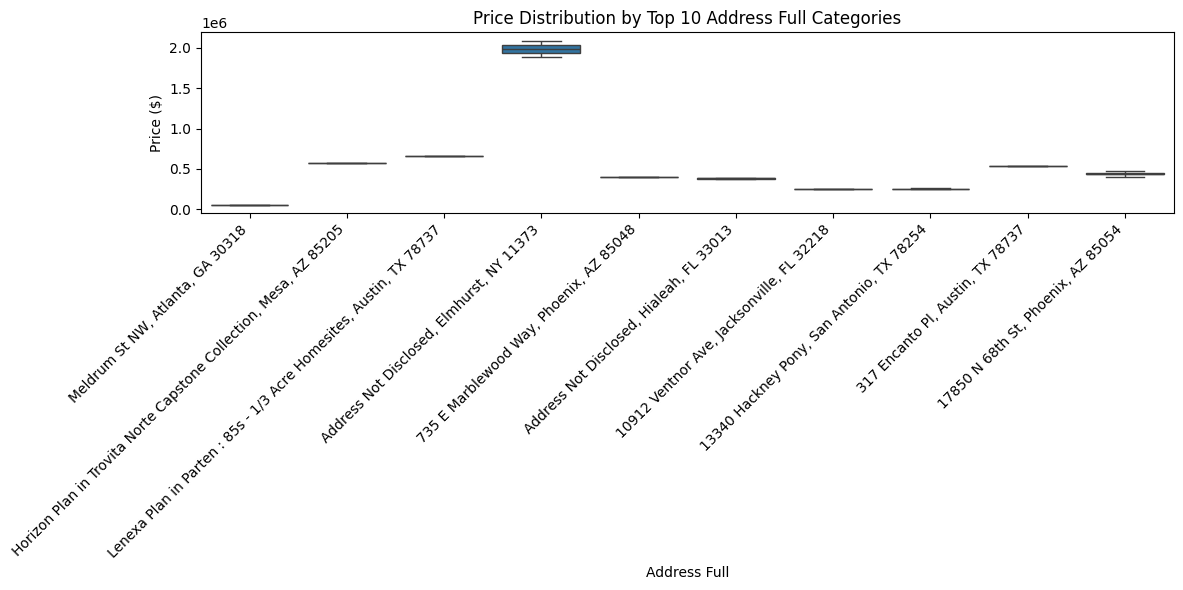

Handling 'Price Sqr Ft ($/sqft)'...


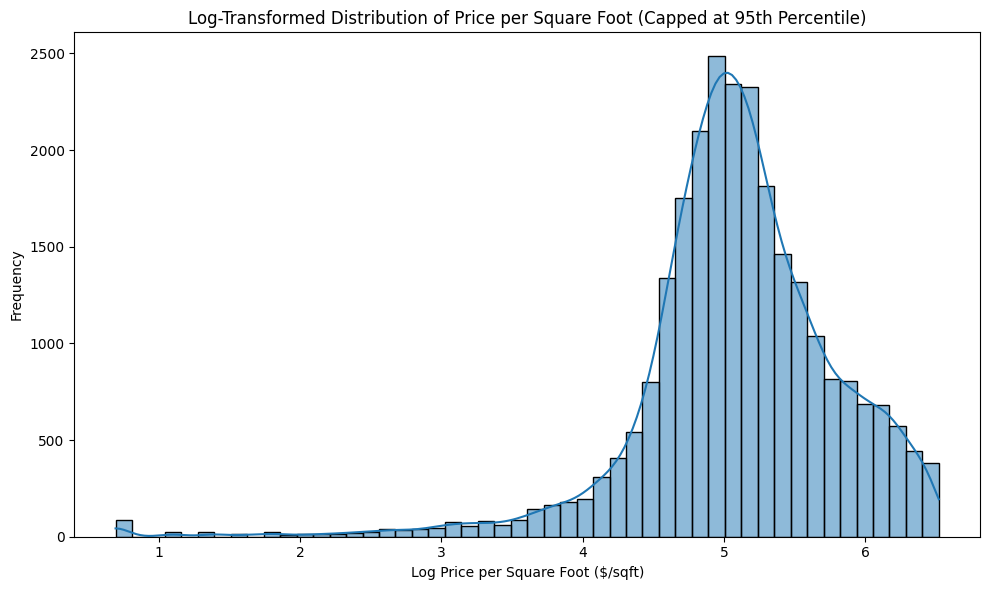

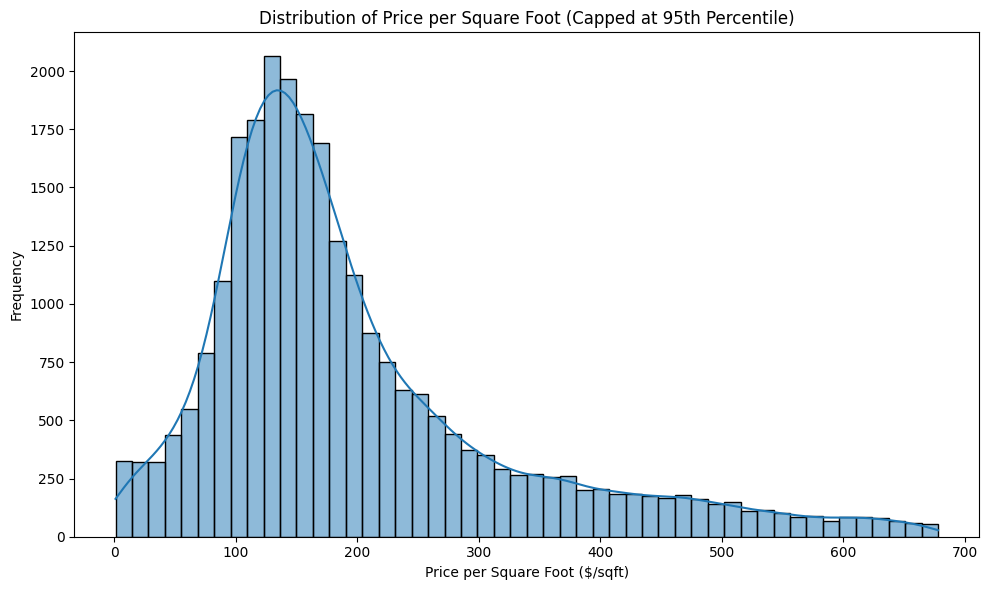

Generating word cloud for Address...


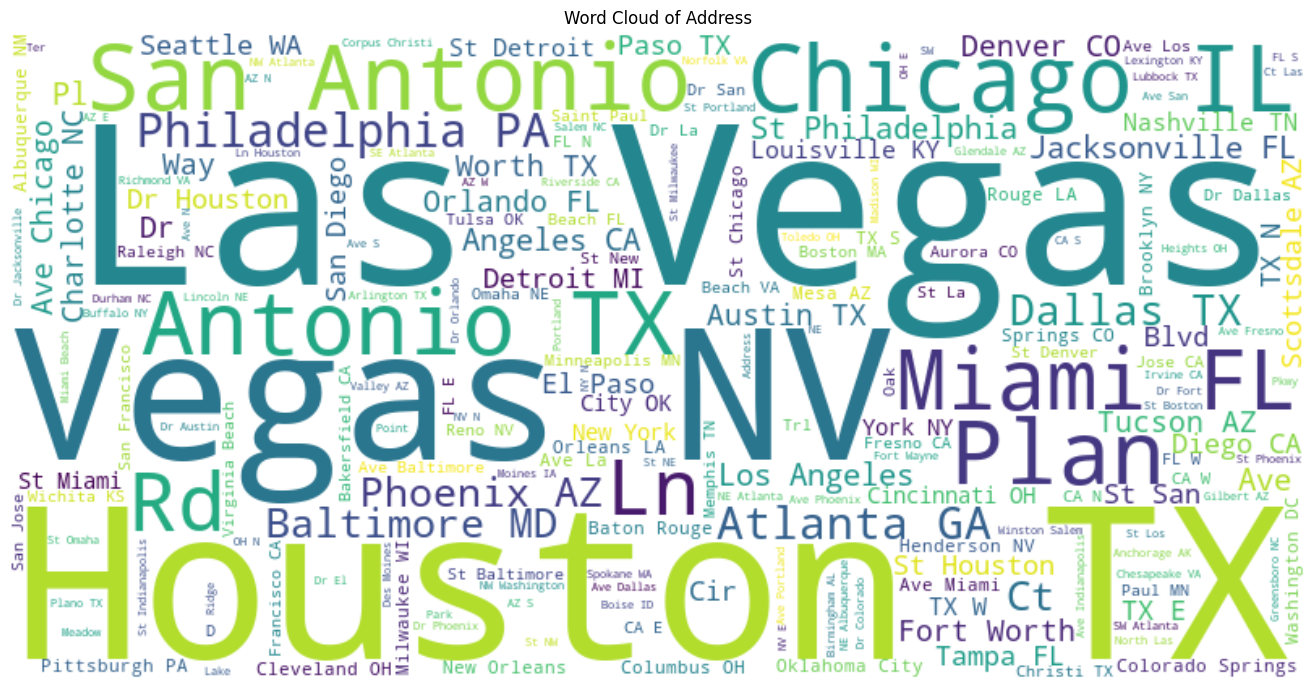

Generating word cloud for Address Full...


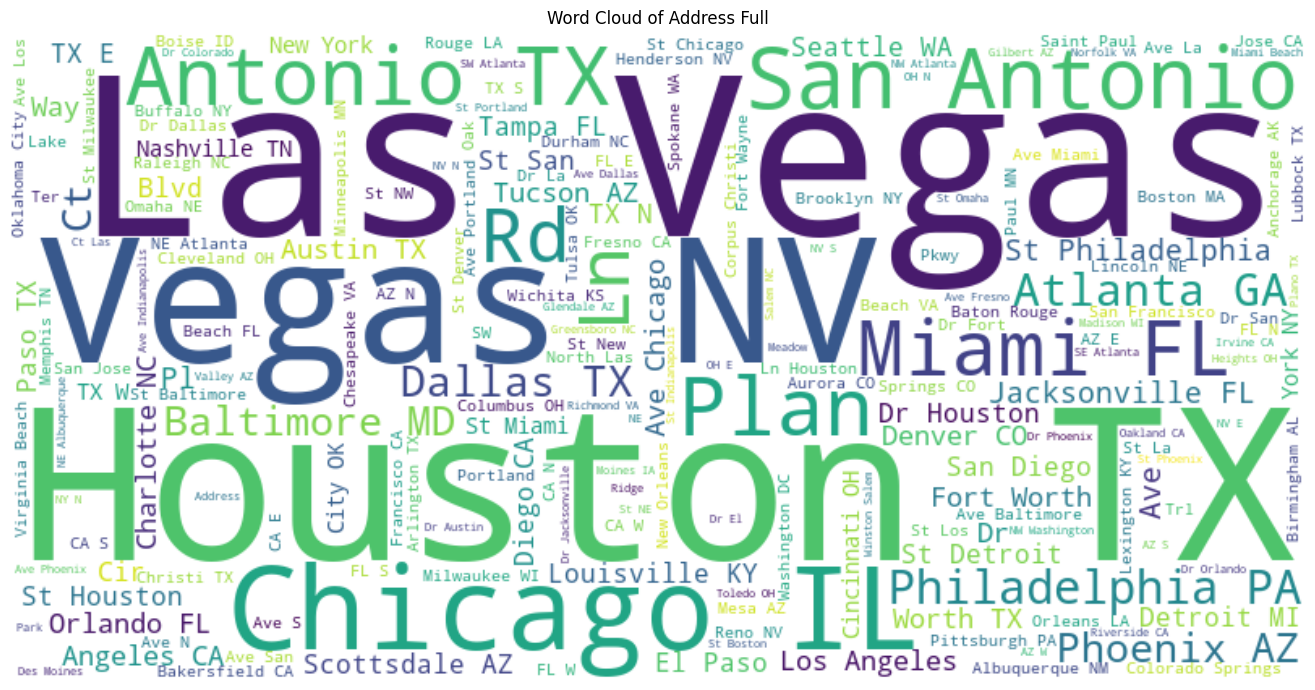

Plotting pair plot for numerical features...


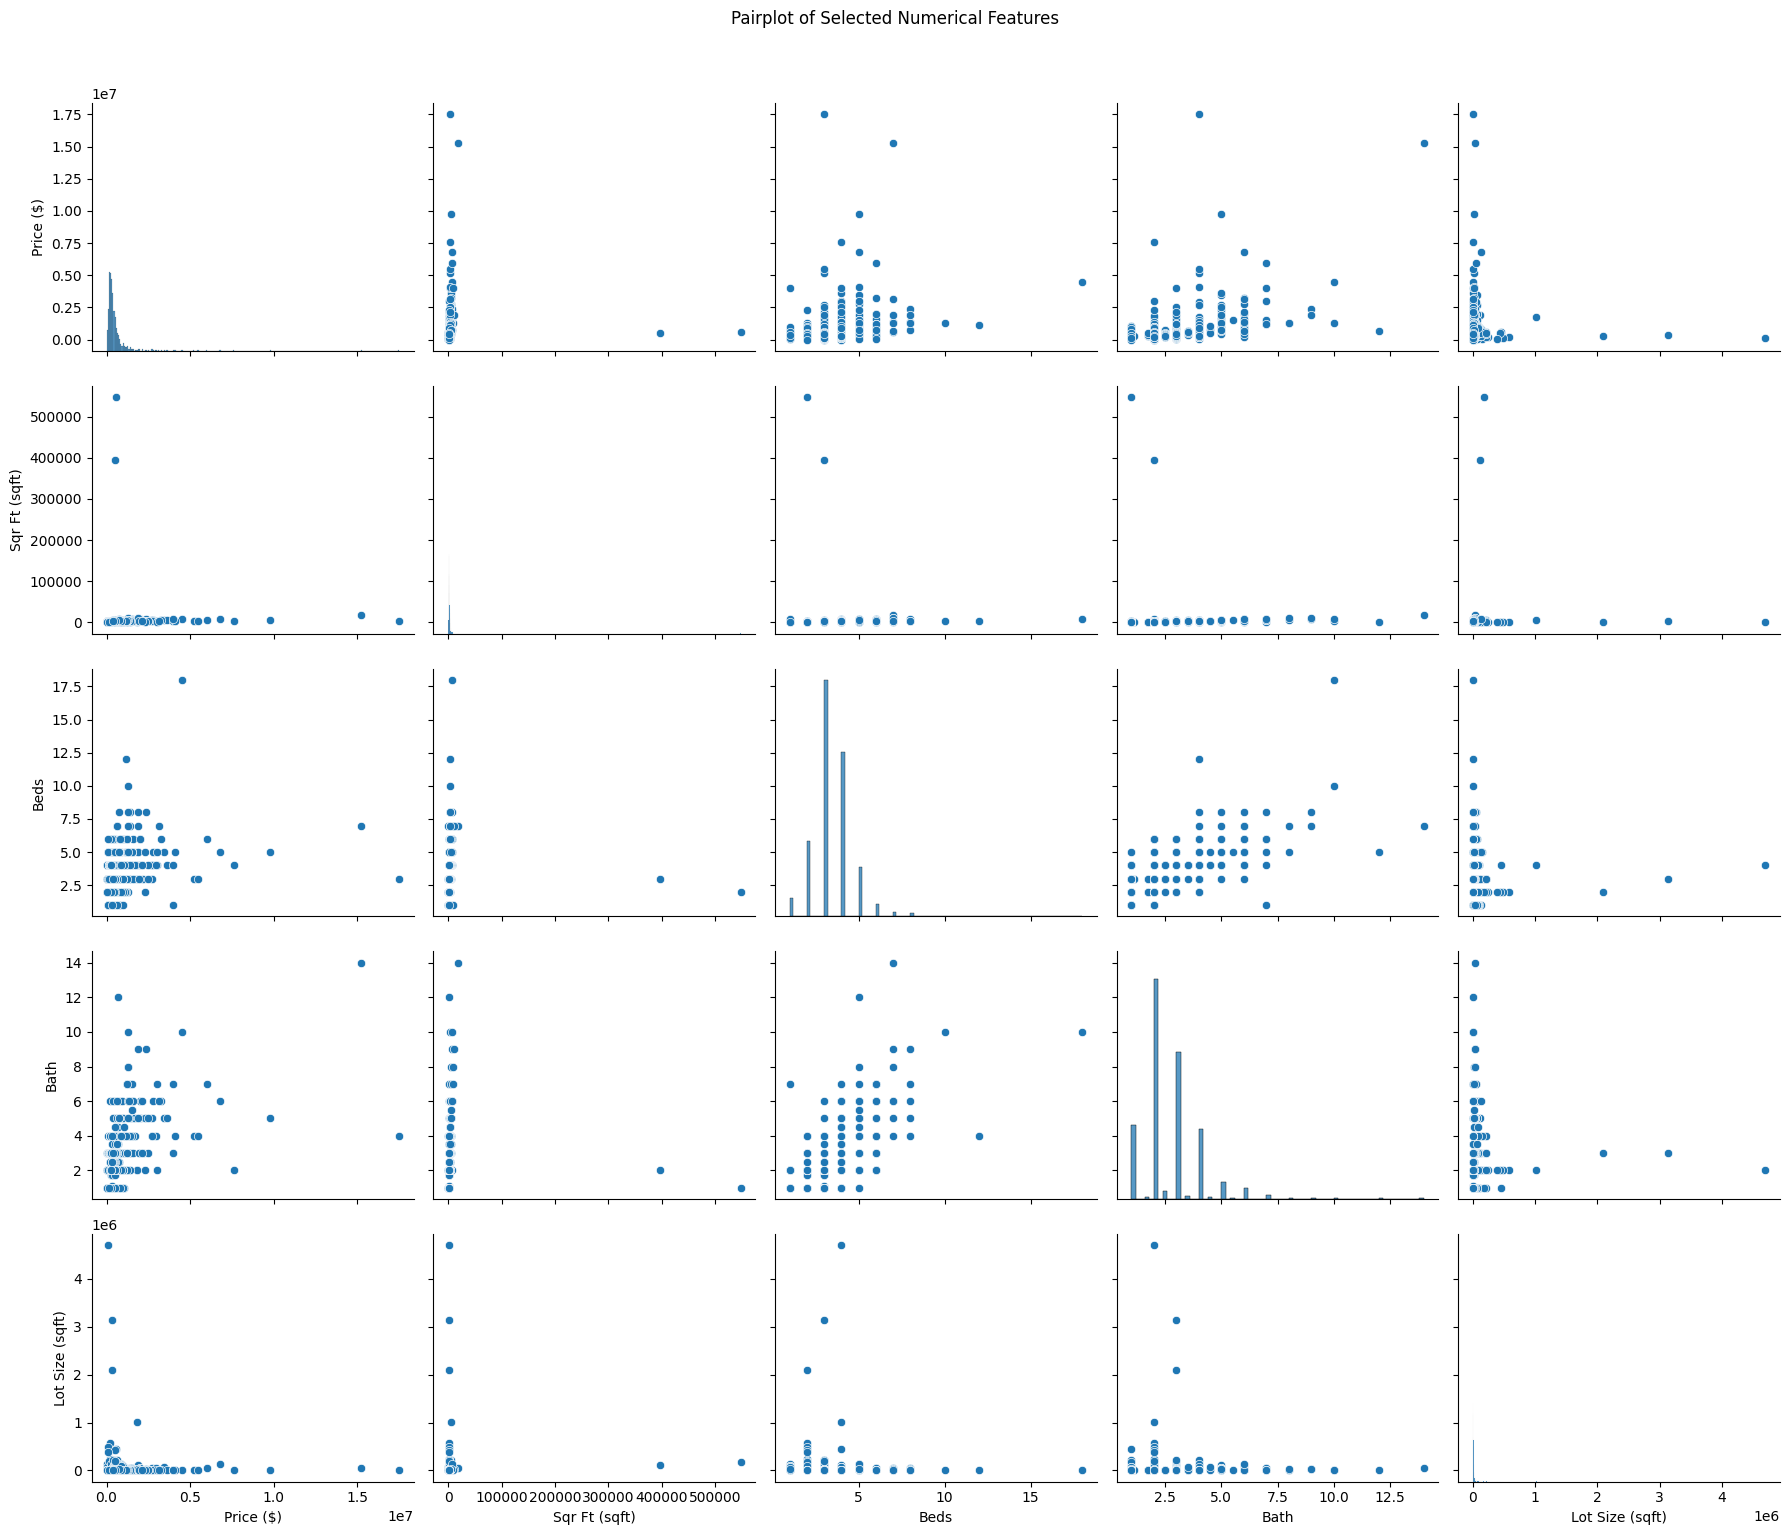

EDA completed successfully.


In [5]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter

# Import WordCloud if available
try:
    from wordcloud import WordCloud
except ImportError:
    WordCloud = None

# Advanced Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        self.numeric_features = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price Sqr Ft ($/sqft)', 'Address', 'City', 'State', 'Address Full']
        self.categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        self.output_folder = "Visualisation Outputs/Advanced EDA Plots"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Convert 'Lot Size (sqft)' from acres to sqft if necessary.
        - Ensure all numeric features are converted to numeric data types.
        - Log transform 'Price ($)'.
        """
        print("Cleaning data...")
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Clean 'Lot Size (sqft)' column
        self.clean_lot_size_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def clean_lot_size_column(self):
        """Clean and convert 'Lot Size (sqft)' to numeric values in sqft."""
        if self.check_column_exists('Lot Size (sqft)'):
            # Apply conversion to each value in 'Lot Size (sqft)'
            self.df['Lot Size (sqft)'] = self.df['Lot Size (sqft)'].apply(self.convert_lot_size)
            # Convert the cleaned values to numeric
            self.df['Lot Size (sqft)'] = pd.to_numeric(self.df['Lot Size (sqft)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    @staticmethod
    def convert_lot_size(value):
        """
        Convert 'Lot Size (sqft)' from acres to sqft if applicable.

        Parameters:
        value: The value to convert.

        Returns:
        float: The converted lot size in sqft, or NaN if conversion fails.
        """
        try:
            if pd.isna(value):
                return np.nan
            value_str = str(value).strip().lower()
            if 'acres' in value_str:
                # Extract the numeric part and convert acres to sqft
                number = float(value_str.replace('acres', '').strip())
                return number * 43560
            else:
                # Remove commas and convert to float
                return float(value_str.replace(',', ''))
        except (ValueError, TypeError):
            return np.nan

    def plot_categorical_boxplots(self):
        """
        Plot box plots for top categories in categorical variables.
        """
        print("Plotting box plots for categorical variables...")
        categorical_cols = [col for col in self.categorical_cols if col != 'Price ($)']
        for col in categorical_cols:
            if self.check_column_exists(col):
                # Get top 10 categories by frequency
                top_categories = self.df[col].value_counts().nlargest(10).index
                df_top = self.df[self.df[col].isin(top_categories)]
                if not df_top.empty:
                    plt.figure(figsize=(12, 6))
                    sns.boxplot(x=col, y='Price ($)', data=df_top)
                    plt.title(f'Price Distribution by Top 10 {col} Categories')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    filename = f'boxplot_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()

    def handle_price_per_sqft(self):
        """
        Clean, transform, and plot 'Price Sqr Ft ($/sqft)' data.
        """
        col = 'Price Sqr Ft ($/sqft)'
        if self.check_column_exists(col):
            print("Handling 'Price Sqr Ft ($/sqft)'...")
            # Clean the data by removing trailing '/'
            self.df[col] = self.df[col].astype(str).str.replace('/', '', regex=False)
            # Convert to numeric
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
            # Drop NaN values and filter out non-positive values
            df_clean = self.df.dropna(subset=[col]).copy()
            df_clean = df_clean[df_clean[col] > 0]
            if not df_clean.empty:
                # Cap outliers at the 95th percentile
                price_cap = df_clean[col].quantile(0.95)
                df_capped = df_clean[df_clean[col] <= price_cap].copy()
                # Apply logarithmic transformation
                df_capped.loc[:, 'Log Price Sqr Ft'] = np.log1p(df_capped[col])
                # Plot the log-transformed, capped distribution
                plt.figure(figsize=(10, 6))
                sns.histplot(df_capped['Log Price Sqr Ft'], bins=50, kde=True)
                plt.title('Log-Transformed Distribution of Price per Square Foot (Capped at 95th Percentile)')
                plt.xlabel('Log Price per Square Foot ($/sqft)')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_folder, 'log_transformed_price_per_sqft.png'))
                plt.show()  # Display the plot
                plt.close()

                # Plot the original distribution (before log transformation)
                plt.figure(figsize=(10, 6))
                sns.histplot(df_capped[col], bins=50, kde=True)
                plt.title('Distribution of Price per Square Foot (Capped at 95th Percentile)')
                plt.xlabel('Price per Square Foot ($/sqft)')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_folder, 'original_price_per_sqft.png'))
                plt.show()  # Display the plot
                plt.close()
            else:
                print("No valid data to plot for 'Price Sqr Ft ($/sqft)'.")

    def plot_wordclouds(self):
        """
        Generate word clouds for 'Address' and 'Address Full' columns, or plot top words.
        """
        for col in ['Address', 'Address Full']:
            if self.check_column_exists(col):
                print(f"Generating word cloud for {col}...")
                if WordCloud:
                    # Generate word cloud
                    text = ' '.join(self.df[col].dropna())
                    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
                    plt.figure(figsize=(15, 7))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud of {col}')
                    plt.tight_layout()
                    filename = f'wordcloud_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()
                else:
                    # Alternative visualization: Top 20 most common words
                    words = ' '.join(self.df[col].dropna()).split()
                    word_counts = Counter(words)
                    common_words = word_counts.most_common(20)
                    plt.figure(figsize=(12, 6))
                    sns.barplot(x=[word for word, _ in common_words], y=[count for _, count in common_words])
                    plt.title(f'Top 20 Most Common Words in {col}')
                    plt.xlabel('Words')
                    plt.ylabel('Count')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    filename = f'top_words_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()

    def plot_pairs_plot(self):
        """
        Plot pair plots for selected numerical features.
        """
        print("Plotting pair plot for numerical features...")
        selected_numeric_cols = ['Price ($)', 'Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)']
        available_numeric_cols = [col for col in selected_numeric_cols if col in self.df.columns]

        if len(available_numeric_cols) >= 2:
            # Sample data if too large
            df_numeric = self.df[available_numeric_cols].dropna()
            if df_numeric.shape[0] > 1000:
                df_sampled = df_numeric.sample(1000, random_state=42)
            else:
                df_sampled = df_numeric

            sns.pairplot(df_sampled, height=3, aspect=1.2)
            plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
            plt.tight_layout()
            filename = 'pairplot_numeric_features.png'
            plt.savefig(os.path.join(self.output_folder, filename))
            plt.show()  # Display the plot
            plt.close()
        else:
            print("Not enough numerical columns available for pair plot.")

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Plot box plots for categorical variables
        - Handle 'Price Sqr Ft ($/sqft)' column
        - Generate word clouds or top words for address columns
        - Plot pair plots for numerical features
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Plot box plots for categorical variables
        self.plot_categorical_boxplots()

        # Handle 'Price Sqr Ft ($/sqft)'
        self.handle_price_per_sqft()

        # Generate word clouds or top words for address columns
        self.plot_wordclouds()

        # Plot pair plot for numerical features
        self.plot_pairs_plot()

        print("EDA completed successfully.")

# Main execution
def main():
    file_path = "cleaned_data.csv"  # Update this path as needed

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print("Error: The dataframe is empty. Unable to perform EDA.")
            else:
                print(f"Data loaded successfully. Shape: {df.shape}")
                eda = ExploratoryDataAnalysis(df)
                eda.perform_eda()
        except Exception as e:
            print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()

#### Model Price Prediction and Heteroscedasticity Handling

##### Note: This code is AI-generated as an experimental implementation of concepts learned beyond the class content.

This section implements a comprehensive approach to predict house prices while addressing potential heteroscedasticity issues. The code performs the following key steps:

1. Data Cleaning: Converts lot sizes, handles missing values, and ensures numeric data types.
2. Feature Engineering: Creates interaction terms and polynomial features to capture complex relationships.
3. Initial Model Fitting: Fits an Ordinary Least Squares (OLS) model and performs visual diagnostics.
4. Heteroscedasticity Testing: Uses Breusch-Pagan and White tests to detect heteroscedasticity.
5. Heteroscedasticity Handling: Applies Box-Cox or log transformations if heteroscedasticity is detected.
6. Model Refitting: Refits the model using transformed data or Weighted Least Squares if necessary.
7. Prediction and Evaluation: Generates predictions, inverts transformations if used, and calculates evaluation metrics.

The code adapts to the presence of heteroscedasticity, employing various statistical techniques to improve model reliability and prediction accuracy. However, it's noted in the Revision Notes.md file that there are still improvements that could be made for more complex projects and datasets. This implementation serves as a foundation, acknowledging that further refinements may be necessary for more sophisticated analyses.



In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns

# Note: AI-generated function to handle lot size conversion.
def convert_lot_size(value):
    """
    Convert 'Lot Size (sqft)' from acres to sqft if applicable.

    Parameters:
    value: The value to convert.

    Returns:
    float: The converted lot size in sqft, or NaN if conversion fails.
    """
    try:
        if pd.isna(value):
            return np.nan
        value_str = str(value).strip().lower()
        if 'acres' in value_str:
            # Extract the numeric part and convert acres to sqft
            number = float(value_str.replace('acres', '').strip())
            return number * 43560
        else:
            # Remove commas and convert to float
            return float(value_str.replace(',', ''))
    except (ValueError, TypeError):
        return np.nan

# Note: AI-generated function that addresses heteroscedasticity creatively.
def model_price_prediction(df):
    """
    Model the data to predict house prices, addressing heteroscedasticity creatively.

    Parameters:
    df: pandas DataFrame containing the relevant columns.

    Returns:
    pandas DataFrame: The original DataFrame with predicted prices added.
    """
    # Ensure required columns are present
    required_cols = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built', 'Price ($)']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Data Cleaning
    # Clean 'Lot Size (sqft)' column
    df['Lot Size (sqft)'] = df['Lot Size (sqft)'].apply(convert_lot_size)
    # Convert to numeric
    df['Lot Size (sqft)'] = pd.to_numeric(df['Lot Size (sqft)'], errors='coerce')

    # Ensure other numeric columns are numeric
    numeric_cols = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Year Built', 'Price ($)']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing values in required columns
    df = df.dropna(subset=required_cols)

    # Prepare features and target variable
    X = df[['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built']].copy()
    y = df['Price ($)'].copy()

    # Feature Engineering
    # Note: AI-generated feature engineering to include interaction and polynomial terms.
    X.loc[:, 'Beds_Bath'] = X['Beds'] * X['Bath']
    X.loc[:, 'Sqr Ft^2'] = X['Sqr Ft (sqft)'] ** 2
    X.loc[:, 'Age'] = 2023 - X['Year Built']

     # Note: AI-generated code to handle skewness in features.
    X.loc[:, 'Lot Size (sqft)'] = X['Lot Size (sqft)'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    X.loc[:, 'Sqr Ft (sqft)'] = X['Sqr Ft (sqft)'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # Add constant term for intercept in the regression model
    X_const = sm.add_constant(X)

    # Note: AI-generated initial model fitting.
    model = sm.OLS(y, X_const).fit()

   # Note: AI-generated visual diagnostics to assess model quality.
    plt.figure(figsize=(8, 6))
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted Values')
    plt.show()

    # Note: AI-generated heteroscedasticity test using Breusch-Pagan.
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    bp_pvalue = bp_test[3]

    # Note: AI-generated heteroscedasticity test using White test.
    white_test = het_white(model.resid, model.model.exog)
    white_pvalue = white_test[3]

    print(f"Breusch-Pagan p-value: {bp_pvalue}")
    print(f"White test p-value: {white_pvalue}")

    used_transformation = False  # Flag to indicate if transformation was used

    # Note: AI-generated logic to determine if heteroscedasticity exists.
    if bp_pvalue < 0.05 or (white_pvalue is not None and white_pvalue < 0.05):
        print("Heteroscedasticity detected. Applying transformations and robust methods.")

        # Note: AI-generated Box-Cox transformation logic for heteroscedasticity.
        if (y <= 0).any():
            print("Cannot apply Box-Cox transformation due to non-positive target values.")
            y_transformed = np.log1p(y)
            transformation = 'Log'
        else:
            y_transformed, lambda_opt = stats.boxcox(y)
            print(f"Applied Box-Cox transformation with lambda: {lambda_opt}")
            transformation = 'Box-Cox'

        # Note: AI-generated refitting of the model after transformation.
        model_transformed = sm.OLS(y_transformed, X_const).fit()

        # Re-test for heteroscedasticity after transformation
        bp_test_transformed = het_breuschpagan(model_transformed.resid, model_transformed.model.exog)
        bp_pvalue_transformed = bp_test_transformed[3]
        white_test_transformed = het_white(model_transformed.resid, model_transformed.model.exog)
        white_pvalue_transformed = white_test_transformed[3]

        print(f"After {transformation} transformation:")
        print(f"Breusch-Pagan p-value: {bp_pvalue_transformed}")
        print(f"White test p-value: {white_pvalue_transformed}")

        if bp_pvalue_transformed >= 0.05 and (white_pvalue_transformed is None or white_pvalue_transformed >= 0.05):
            print("Heteroscedasticity resolved after transformation.")
            used_transformation = True  # Transformation was effective
            # Update the DataFrame with transformed target
            df['Transformed Price'] = y_transformed
            final_model = model_transformed
        else:
            print("Heteroscedasticity persists. Using Weighted Least Squares.")
            used_transformation = False  # Final model uses untransformed target
             # Note: AI-generated calculation of weights for Weighted Least Squares (WLS).
            weights = 1 / np.abs(model.resid)
            model_wls = sm.WLS(y, X_const, weights=weights).fit()
            final_model = model_wls
    else:
        print("No significant heteroscedasticity detected.")
        final_model = model

    # Display model summary for interpretation
    print(final_model.summary())

     # Note: AI-generated prediction and evaluation section.
    predictions = final_model.predict(X_const)

      # Note: AI-generated code for inverting transformation where applicable.
    if used_transformation:
        if transformation == 'Log':
            predictions = np.expm1(predictions)
        elif transformation == 'Box-Cox':
            # Inverse Box-Cox transformation
            predictions = special.inv_boxcox(predictions, lambda_opt)

    # Check for NaNs in predictions and handle them
    if np.isnan(predictions).any():
        print("Warning: Predictions contain NaN values. These will be dropped for evaluation.")
        # Remove NaNs from predictions and corresponding y values
        valid_idx = ~np.isnan(predictions)
        predictions = predictions[valid_idx]
        y = y.iloc[valid_idx]
    else:
        valid_idx = slice(None)  # All indices are valid

  # Note: AI-generated evaluation metrics calculation for model performance.
    from sklearn.metrics import mean_squared_error, r2_score
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"\nModel Evaluation:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Update the DataFrame with predictions
    df.loc[df.index[valid_idx], 'Predicted Price'] = predictions

    return df

# Apply the function to your DataFrame
if not df.empty:
    df = model_price_prediction(df)


##### Split Data into Training and Testing Sets
    Note: This step is not strictly necessary for our Main Task, but it's included as it represents a standard industry practice for preparing data for AI models and competitions, particularly on platforms like Kaggle. The following code is AI-generated to demonstrate this process.

    This section demonstrates how to split the data into training and testing sets using stratified sampling. It also includes feature engineering steps before the split. Here's what the code does:

        1. Loads the cleaned data from a CSV file.
        2. Defines a function `split_data` that:
            - Checks for required columns in the DataFrame.
            - Performs feature engineering (creating new features like 'Age', 'Beds_Bath', and 'Sqr Ft^2').
            - Selects relevant features and the target variable.
            - Handles missing values and applies log transformations to skewed features.
            - Uses stratified sampling based on binned log-transformed target variable to split the data.
        3. Splits the data into training and testing sets.
        4. Saves the split data into separate CSV files for training and testing.

    This approach ensures a more robust split that maintains the distribution of the target variable across both sets, which is crucial for model evaluation in real-world scenarios and competitions.


In [7]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import pandas as pd
import os

# Load the data
df = pd.read_csv(r'G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\cleaned_data.csv')

# Advanced Data Splitting Function
def split_data(df):
    """
    Split the data into training and testing sets using stratified sampling
    and perform feature engineering before splitting.
    """
    # Ensure required columns are present
    required_cols = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built', 'Price ($)']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Feature Engineering
    df = df.copy()
    df['Age'] = 2023 - df['Year Built']
    df['Beds_Bath'] = df['Beds'] * df['Bath']
    df['Sqr Ft^2'] = df['Sqr Ft (sqft)'] ** 2

    # Select features and target
    features = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Age', 'Beds_Bath', 'Sqr Ft^2']
    X = df[features].copy()  # Create a copy to avoid SettingWithCopyWarning
    y = df['Price ($)'].copy()

    # Convert columns to numeric, coercing errors to NaN
    for col in X.columns:
        X.loc[:, col] = pd.to_numeric(X[col], errors='coerce')
    y = pd.to_numeric(y, errors='coerce')

    # Handle missing values
    X = X.fillna(X.median())
    y = y.fillna(y.median())

    # Apply log transformation to skewed features
    X.loc[:, 'Lot Size (sqft)'] = X['Lot Size (sqft)'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    X.loc[:, 'Sqr Ft (sqft)'] = X['Sqr Ft (sqft)'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    y = np.log1p(y)  # Log-transform the target variable

    # Stratify based on the target variable
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    y_binned = discretizer.fit_transform(y.values.reshape(-1, 1)).reshape(-1)

    # Split into training and testing sets with stratification
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_binned
    )

    # Inverse transform the target variable for actual values
    y_train = np.expm1(y_train_log)
    y_test = np.expm1(y_test_log)

    print("Data split using stratified sampling based on binned log-transformed target variable.")
    return X_train, X_test, y_train, y_test

# Check if the DataFrame is empty
if not df.empty:
    X_train, X_test, y_train, y_test = split_data(df)

    # Create directories for train and test data
    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)

    # Save train data
    pd.concat([X_train, pd.Series(y_train, name='Price ($)')], axis=1).to_csv('train/train_data.csv', index=False)

    # Save test data
    pd.concat([X_test, pd.Series(y_test, name='Price ($)')], axis=1).to_csv('test/test_data.csv', index=False)

    print("Train and test data saved to separate folders.")
else:
    print("DataFrame is empty. Please check your data source.")


Data split using stratified sampling based on binned log-transformed target variable.
Train and test data saved to separate folders.


C:\Users\22837352\AppData\Local\Temp\ipykernel_48948\3676719985.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(X.median())


#### Model Building

Mean Squared Error (Linear Regression): 9.691e+11
R2 Score (Linear Regression): 0.1223
Mean Squared Error (Polynomial Regression Degree 2): 7.644e+11
R2 Score (Polynomial Regression Degree 2): 0.3076
Mean Squared Error (SGD Regression): 1.92e+12
R2 Score (SGD Regression): -0.7388
Mean Squared Error (Mini-Batch Gradient Descent): 1.779e+12
R2 Score (Mini-Batch Gradient Descent): -0.6114


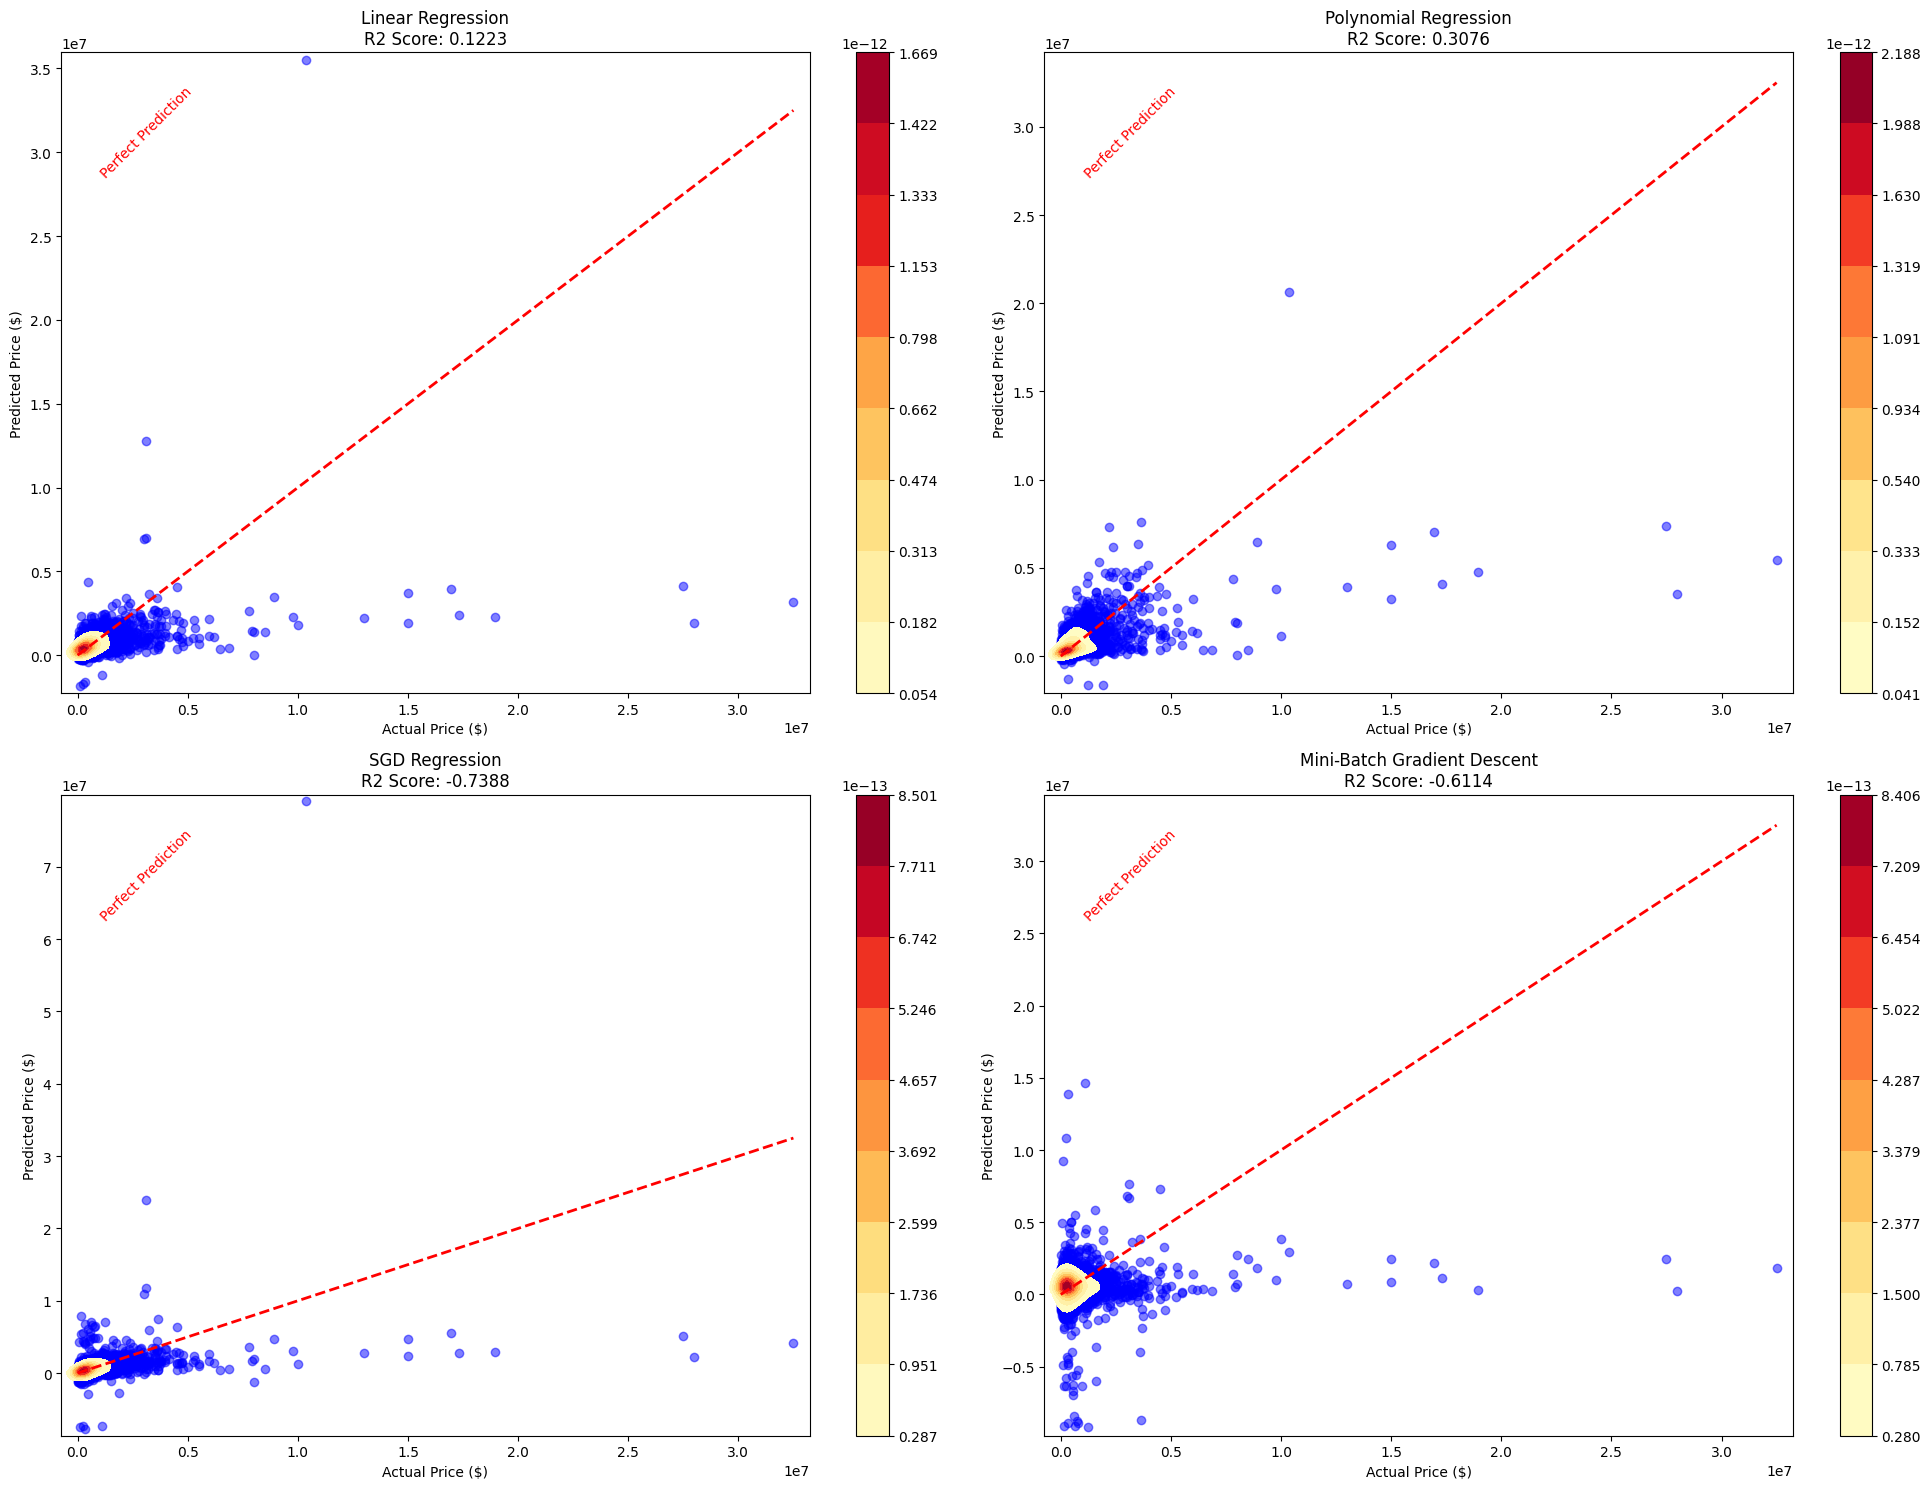

Could not plot density plot for SGD Regression Residuals: Contour levels must be increasing


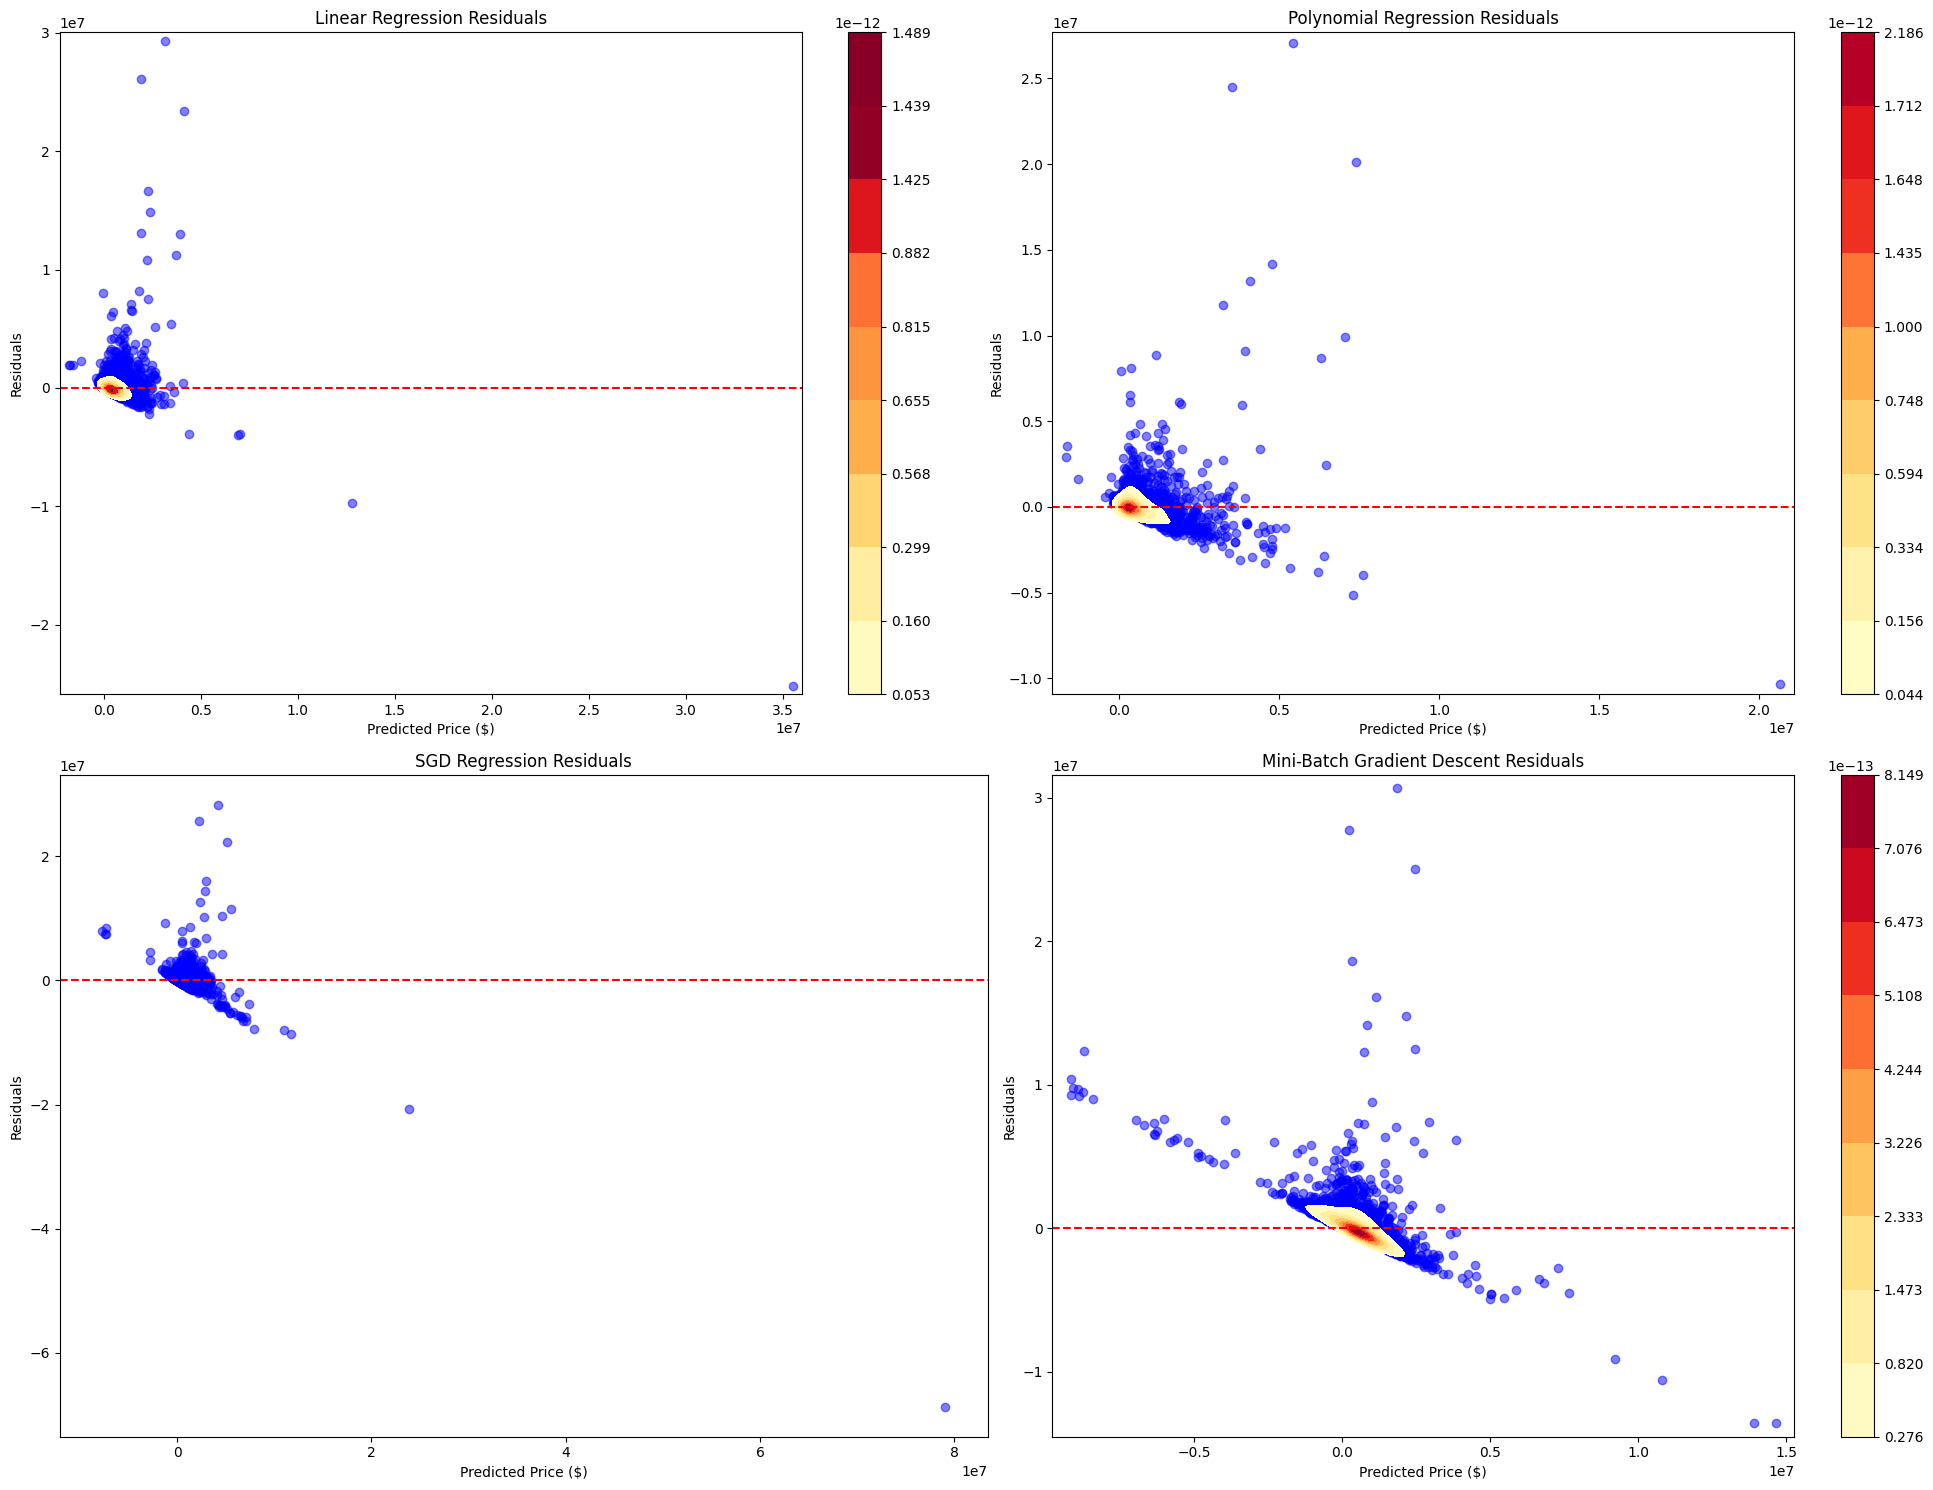

Model Building and Evaluation Complete


In [31]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

# Load Dataset
train_data = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\train\train_data.csv")
test_data = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\test\test_data.csv")

# Data Preparation
X_train = train_data.drop("Price ($)", axis=1)
y_train = train_data["Price ($)"]
X_test = test_data.drop("Price ($)", axis=1)
y_test = test_data["Price ($)"]

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Linear Regression using Closed Form Solution
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train_scaled)

# Predictions and Evaluation
y_pred_linear_scaled = linear_model.predict(X_test_scaled)
y_pred_linear = scaler_y.inverse_transform(y_pred_linear_scaled.reshape(-1, 1)).flatten()
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Mean Squared Error (Linear Regression): {mse_linear:.4g}")
print(f"R2 Score (Linear Regression): {r2_linear:.4g}")

# Polynomial Regression (Degree 2)
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train_scaled = poly_features.fit_transform(X_train_scaled)
X_poly_test_scaled = poly_features.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_poly_train_scaled, y_train_scaled)

# Predictions and Evaluation
y_pred_poly_scaled = poly_model.predict(X_poly_test_scaled)
y_pred_poly = scaler_y.inverse_transform(y_pred_poly_scaled.reshape(-1, 1)).flatten()
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Mean Squared Error (Polynomial Regression Degree 2): {mse_poly:.4g}")
print(f"R2 Score (Polynomial Regression Degree 2): {r2_poly:.4g}")

# Stochastic Gradient Descent (SGD) for Linear Regression
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train_scaled, y_train_scaled)

# Predictions and Evaluation
y_pred_sgd_scaled = sgd_model.predict(X_test_scaled)
y_pred_sgd = scaler_y.inverse_transform(y_pred_sgd_scaled.reshape(-1, 1)).flatten()
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)
print(f"Mean Squared Error (SGD Regression): {mse_sgd:.4g}")
print(f"R2 Score (SGD Regression): {r2_sgd:.4g}")

# Mini-Batch Gradient Descent
def mini_batch_gradient_descent(X, y, learning_rate=1e-5, batch_size=32, n_epochs=100):
    m, n = X.shape
    theta = np.random.randn(n, 1)
    y = y.reshape(-1, 1)
    
    for epoch in range(n_epochs):
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        
        for i in range(0, m, batch_size):
            xi = X_shuffled[i:i+batch_size]
            yi = y_shuffled[i:i+batch_size]
            gradients = 2/batch_size * xi.T.dot(xi.dot(theta) - yi)
            theta = theta - learning_rate * gradients
    
    return theta

# Apply Mini-Batch Gradient Descent
X_train_mb, X_val_mb, y_train_mb, y_val_mb = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

theta_mb = mini_batch_gradient_descent(X_train_mb, y_train_mb, learning_rate=1e-5, batch_size=32, n_epochs=100)
y_pred_mb_scaled = X_test_scaled.dot(theta_mb)
y_pred_mb = scaler_y.inverse_transform(y_pred_mb_scaled).flatten()
mse_mb = mean_squared_error(y_test, y_pred_mb)
r2_mb = r2_score(y_test, y_pred_mb)
print(f"Mean Squared Error (Mini-Batch Gradient Descent): {mse_mb:.4g}")
print(f"R2 Score (Mini-Batch Gradient Descent): {r2_mb:.4g}")

# Validate Predictions
def validate_predictions(y_pred):
    if np.isnan(y_pred).any() or np.isinf(y_pred).any():
        return False
    return True

# Plotting Results
plt.figure(figsize=(20, 15))

# Function to plot regression results
def plot_regression_results(ax, y_true, y_pred, title, r2):
    ax.scatter(y_true, y_pred, color='blue', alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_title(f'{title}\nR2 Score: {r2:.4g}')
    ax.set_xlabel('Actual Price ($)')
    ax.set_ylabel('Predicted Price ($)')
    
    # Add density plot
    try:
        if len(np.unique(y_true)) > 1 and len(np.unique(y_pred)) > 1:
            sns.kdeplot(x=y_true, y=y_pred, cmap="YlOrRd", fill=True, cbar=True, ax=ax, levels=np.linspace(0.1, 1, 10))
    except Exception as e:
        print(f"Could not plot density plot for {title}: {e}")
    
    # Add text for perfect prediction line
    ax.text(0.05, 0.95, 'Perfect Prediction', transform=ax.transAxes,
            fontsize=10, va='top', rotation=45, color='red')

# Linear Regression
ax1 = plt.subplot(2, 2, 1)
plot_regression_results(ax1, y_test, y_pred_linear, 'Linear Regression', r2_linear)

# Polynomial Regression
ax2 = plt.subplot(2, 2, 2)
plot_regression_results(ax2, y_test, y_pred_poly, 'Polynomial Regression', r2_poly)

# SGD Regression
ax3 = plt.subplot(2, 2, 3)
if validate_predictions(y_pred_sgd):
    plot_regression_results(ax3, y_test, y_pred_sgd, 'SGD Regression', r2_sgd)
else:
    print("Invalid predictions for SGD Regression. Skipping plot.")

# Mini-Batch Gradient Descent
ax4 = plt.subplot(2, 2, 4)
if validate_predictions(y_pred_mb):
    plot_regression_results(ax4, y_test, y_pred_mb, 'Mini-Batch Gradient Descent', r2_mb)
else:
    print("Invalid predictions for Mini-Batch Gradient Descent. Skipping plot.")

plt.tight_layout()
plt.savefig(r'G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\Visualisation Outputs\model predictions plots\regression_results.png')
plt.show()

# Residual plots
plt.figure(figsize=(20, 15))

def plot_residuals(ax, y_true, y_pred, title):
    residuals = y_true - y_pred
    ax.scatter(y_pred, residuals, color='blue', alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Predicted Price ($)')
    ax.set_ylabel('Residuals')
    
    try:
        # Add density plot for residuals
        if len(np.unique(y_pred)) > 1 and len(np.unique(residuals)) > 1:
            sns.kdeplot(x=y_pred, y=residuals, cmap="YlOrRd", fill=True, cbar=True, ax=ax, levels=np.linspace(0.1, 1, 10))
    except Exception as e:
        print(f"Could not plot density plot for {title}: {e}")

# Linear Regression Residuals
ax1 = plt.subplot(2, 2, 1)
plot_residuals(ax1, y_test, y_pred_linear, 'Linear Regression Residuals')

# Polynomial Regression Residuals
ax2 = plt.subplot(2, 2, 2)
plot_residuals(ax2, y_test, y_pred_poly, 'Polynomial Regression Residuals')

# SGD Regression Residuals
ax3 = plt.subplot(2, 2, 3)
if validate_predictions(y_pred_sgd):
    plot_residuals(ax3, y_test, y_pred_sgd, 'SGD Regression Residuals')
else:
    print("Invalid predictions for SGD Regression. Skipping residual plot.")

# Mini-Batch Gradient Descent Residuals
ax4 = plt.subplot(2, 2, 4)
if validate_predictions(y_pred_mb):
    plot_residuals(ax4, y_test, y_pred_mb, 'Mini-Batch Gradient Descent Residuals')
else:
    print("Invalid predictions for Mini-Batch Gradient Descent. Skipping residual plot.")

plt.tight_layout()
plt.savefig(r'G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\Visualisation Outputs\model predictions plots\residual_plots.png')
plt.show()

# Add this at the end of the cell
print("Model Building and Evaluation Complete")

#### Model Evaluation

#### Address Overfitting

#### Conclusion and Recommendations